<a href="https://colab.research.google.com/github/mbolaris/shark-data-analysis/blob/main/shark_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook presents an in-depth analysis of white shark movement data, with a focus on understanding the relationship between depth and Overall Dynamic Body Acceleration (ODBA) over time. Utilizing a rich dataset, the study aims to decipher patterns in shark behavior and energy expenditure. Through a combination of data cleaning, visualization, and analytical techniques, we explore how these magnificent creatures interact with their aquatic environment. Our findings have potential implications for marine biology, conservation efforts, and the broader ecological understanding of shark behaviors in their natural habitat.

## Data Overview

- **Comment**: CEFAS 1 Female 4.5

- **Tag ID**: A14243
- **Firmware**: Version 3, Build Level 70
- **Pressure Range**: 50 units
- **Sensors Count**: 5
- **Deployment Duration**: October 15, 2017, to November 30, 2017

**Mission Parameters**
- **Dive Termination**: 1.5% percentage, 7.5m depth
- **Gravity Range**: 2g
- **Operational Days**: 51

**Data Sampling**
- **Logging Rate**: 1 per minute
- **Resolution**: 12 bits

The dataset contains time-stamped measurements of pressure, temperature, and tri-axial acceleration. These metrics are used to assess the shark's movement behavior.

# Analysis

## Import Libraries

In [1]:
# Install Astral (if needed)
%pip install astral

# Standard library imports
from datetime import datetime, timedelta
import json
import os
import sys

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pytz import timezone
from astral import LocationInfo
from astral.sun import sun

from matplotlib.colors import LinearSegmentedColormap


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Data Loading

In [2]:
# Check if the notebook is running on Google Colab
running_on_colab = 'google.colab' in sys.modules

if running_on_colab:
    # Google Colab specific imports
    from google.colab import auth, drive

    # Authenticate and mount the drive
    auth.authenticate_user()
    drive.mount('/content/drive')
    
    # Set the base path for data on Google Drive
    base_path = '/content/drive/MyDrive/shark-data/'
else:
    # Set the base path for local data
    base_path = 'C:/shared/shark-data/'

# Now you can load your data using the base path
data_file_path = os.path.join(base_path, 'A14243_23-10-2017.csv')

# Load the data
data = pd.read_csv(data_file_path, skiprows=59)

## Data Cleaning

In [3]:
# Assuming your 'Time Stamp' column is a string in the format '15/10/17 14:45'
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'], format='%d/%m/%y %H:%M', errors='coerce')
data.dropna(subset=['Time Stamp'], inplace=True)

# Clean the data filter out invalid pressure, temperature values
data = data[(~data['Pressure'].isna()) & (data['Pressure'] != np.inf) & (data['Pressure'] != -np.inf) &
            (~data['Temp'].isna()) & (data['Temp'] != np.inf) & (data['Temp'] != -np.inf)]

## Data Transformation

### Calculating ODBA
ODBA is calculated to represent sharks' locomotor activity, serving as an energy expenditure proxy.

In [4]:
# Calculate ODBA as the sum of the absolute values of the dynamic accelerations
data['ODBA'] = data[['X Axis', 'Y Axis', 'Z Axis']].abs().sum(axis=1)

### Calculating Day-Night Cycle Times

In [5]:
# Define the location and timezone for sunrise/sunset calculations
city = LocationInfo('Ensenada', 'Mexico', 'America/Tijuana', 31.8654, -116.5964)
local_tz = timezone('America/Tijuana')

# Convert 'Time Stamp' to datetime, if not already done
data['Time Stamp'] = pd.to_datetime(data['Time Stamp'])

# Prepare a dictionary to hold sunrise and sunset times
sun_cycles = {}

for date in data['Time Stamp'].dt.date.unique():
    s = sun(city.observer, date=date, tzinfo=local_tz)
    sun_cycles[date] = {'sunrise': s['sunrise'].replace(tzinfo=None),
                        'sunset': s['sunset'].replace(tzinfo=None)}

## Data Visualization

### Depth over Time with Temperature Color Coding and Day/Night Bands
Depth over time graph, with temperature color-coding and day/night bands, illustrates how sharks' movement patterns are influenced by environmental and temporal factors.

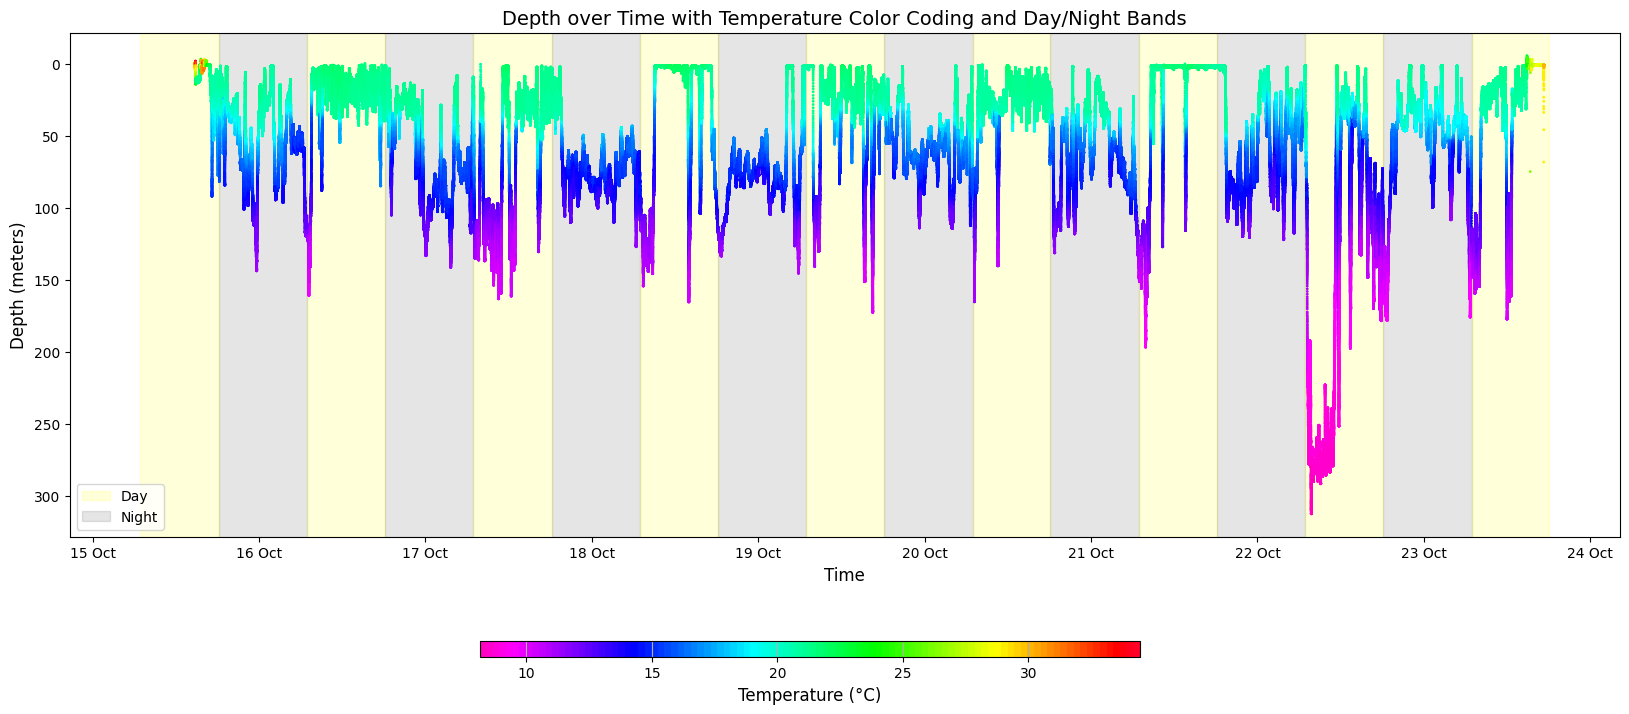

In [29]:
# Initialize plot
plt.figure(figsize=(20, 8))

# Plot day-night bands using the sun_cycles dictionary
for date, times in sun_cycles.items():
    sunrise = times['sunrise']
    sunset = times['sunset']
    plt.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day')
    
    # Handling the night span
    if date != data['Time Stamp'].dt.date.max():
        next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
        plt.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night')

# Use a predefined colormap
cmap = plt.get_cmap('gist_rainbow', 100).reversed()
norm = plt.Normalize(vmin=data['Temp'].min(), vmax=data['Temp'].max())

# Plot depth data against time, colored by temperature
sc = plt.scatter(data['Time Stamp'], data['Pressure'], c=data['Temp'], cmap=cmap, norm=norm, s=1, alpha=1.0)
plt.gca().invert_yaxis()

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Only add the legend for day/night once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left')

# Set plot titles and labels
plt.title('Depth over Time with Temperature Color Coding and Day/Night Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Depth (meters)', fontsize=12)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.25)

# Adjust the position of the colorbar
colorbar_axes = plt.gcf().add_axes([0.33, 0.1, 0.33, 0.02])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')

# Set the label for the colorbar
cbar.set_label('Temperature (°C)', fontsize=12)

# Set the grid for better readability
plt.grid(True)

# Show the plot
plt.show()

### ODBA over Time with Day/Night Bands
The graph shows sharks' Overall Dynamic Body Acceleration (ODBA) over time, marked with day (yellow) and night (black) bands.

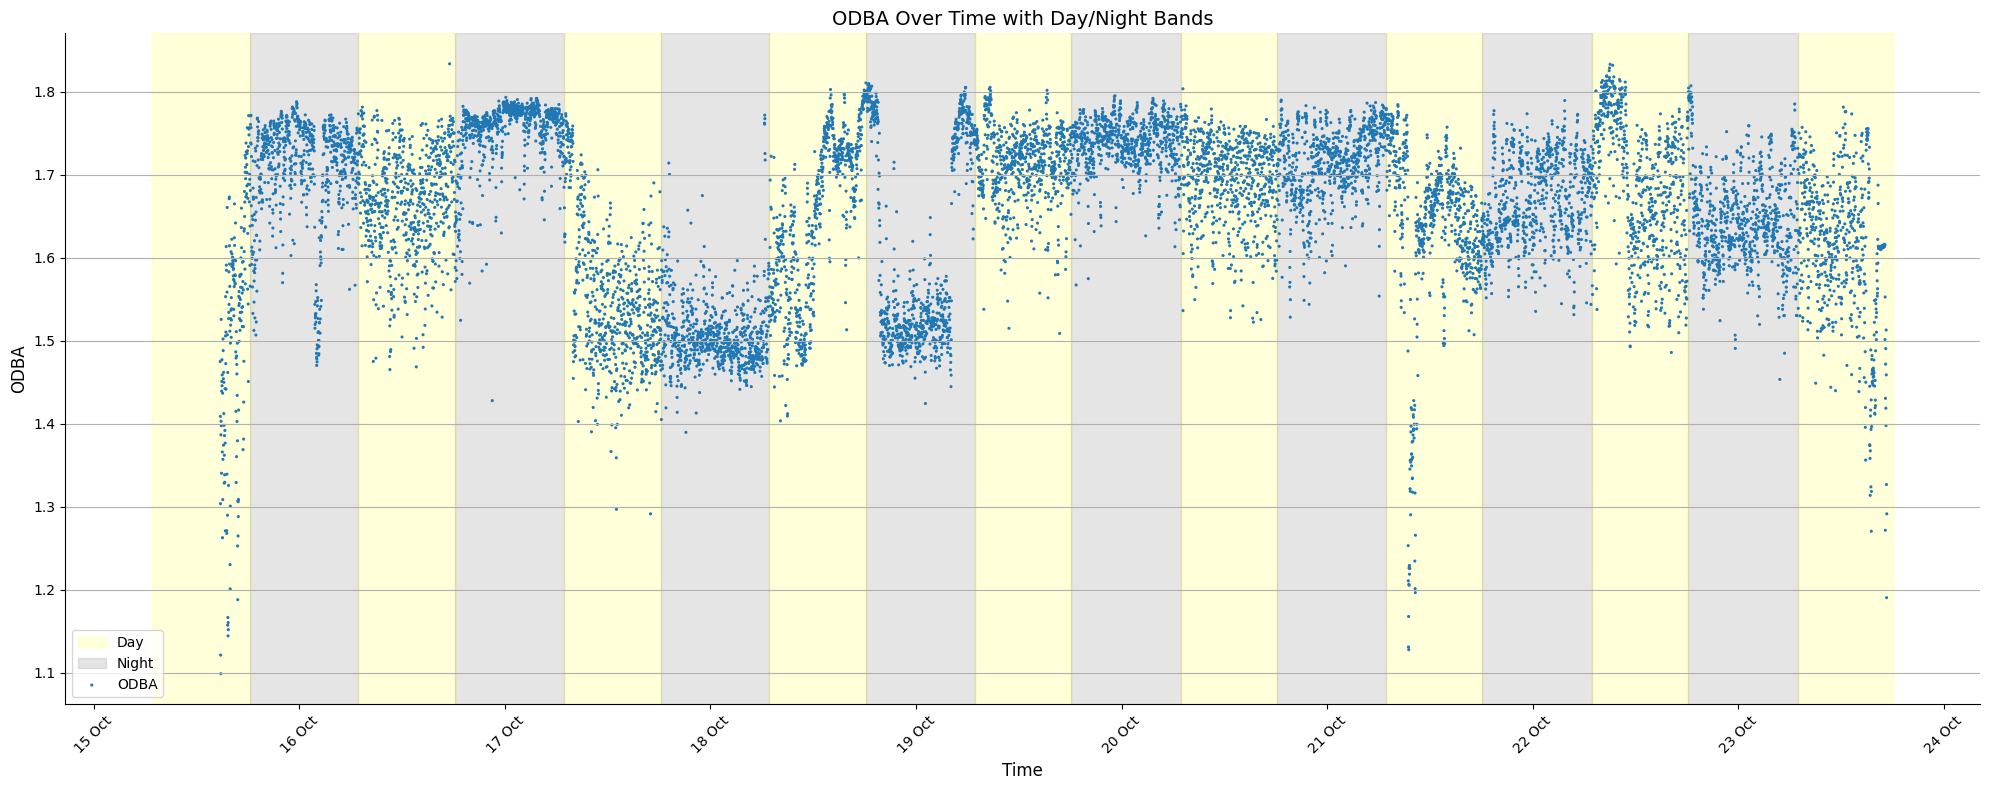

In [30]:
# Initialize plot
plt.figure(figsize=(20, 8))

# Plot day-night bands using the sun_cycles dictionary
for date, times in sun_cycles.items():
    sunrise = times['sunrise']
    sunset = times['sunset']
    plt.axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15, label='Day')
    
    # Handling the night span
    if date != data['Time Stamp'].dt.date.max():
        next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
        plt.axvspan(sunset, next_day_sunrise, color='black', alpha=0.1, label='Night')

resampled_data = data.resample('min', on='Time Stamp').mean()

# Scatter plot for ODBA values over time
plt.scatter(resampled_data.index, resampled_data['ODBA'], s=5, alpha=1, color='tab:blue', edgecolor='none', label='ODBA')

# Format the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Only add the legend for day/night once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower left')

# Set plot titles and labels
plt.title('ODBA Over Time with Day/Night Bands', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('ODBA', fontsize=12)
plt.xticks(rotation=45)

# Add horizontal grid for better readability
plt.grid(True, axis='y')

# Remove top and right spines for a cleaner look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.tight_layout()
plt.show()

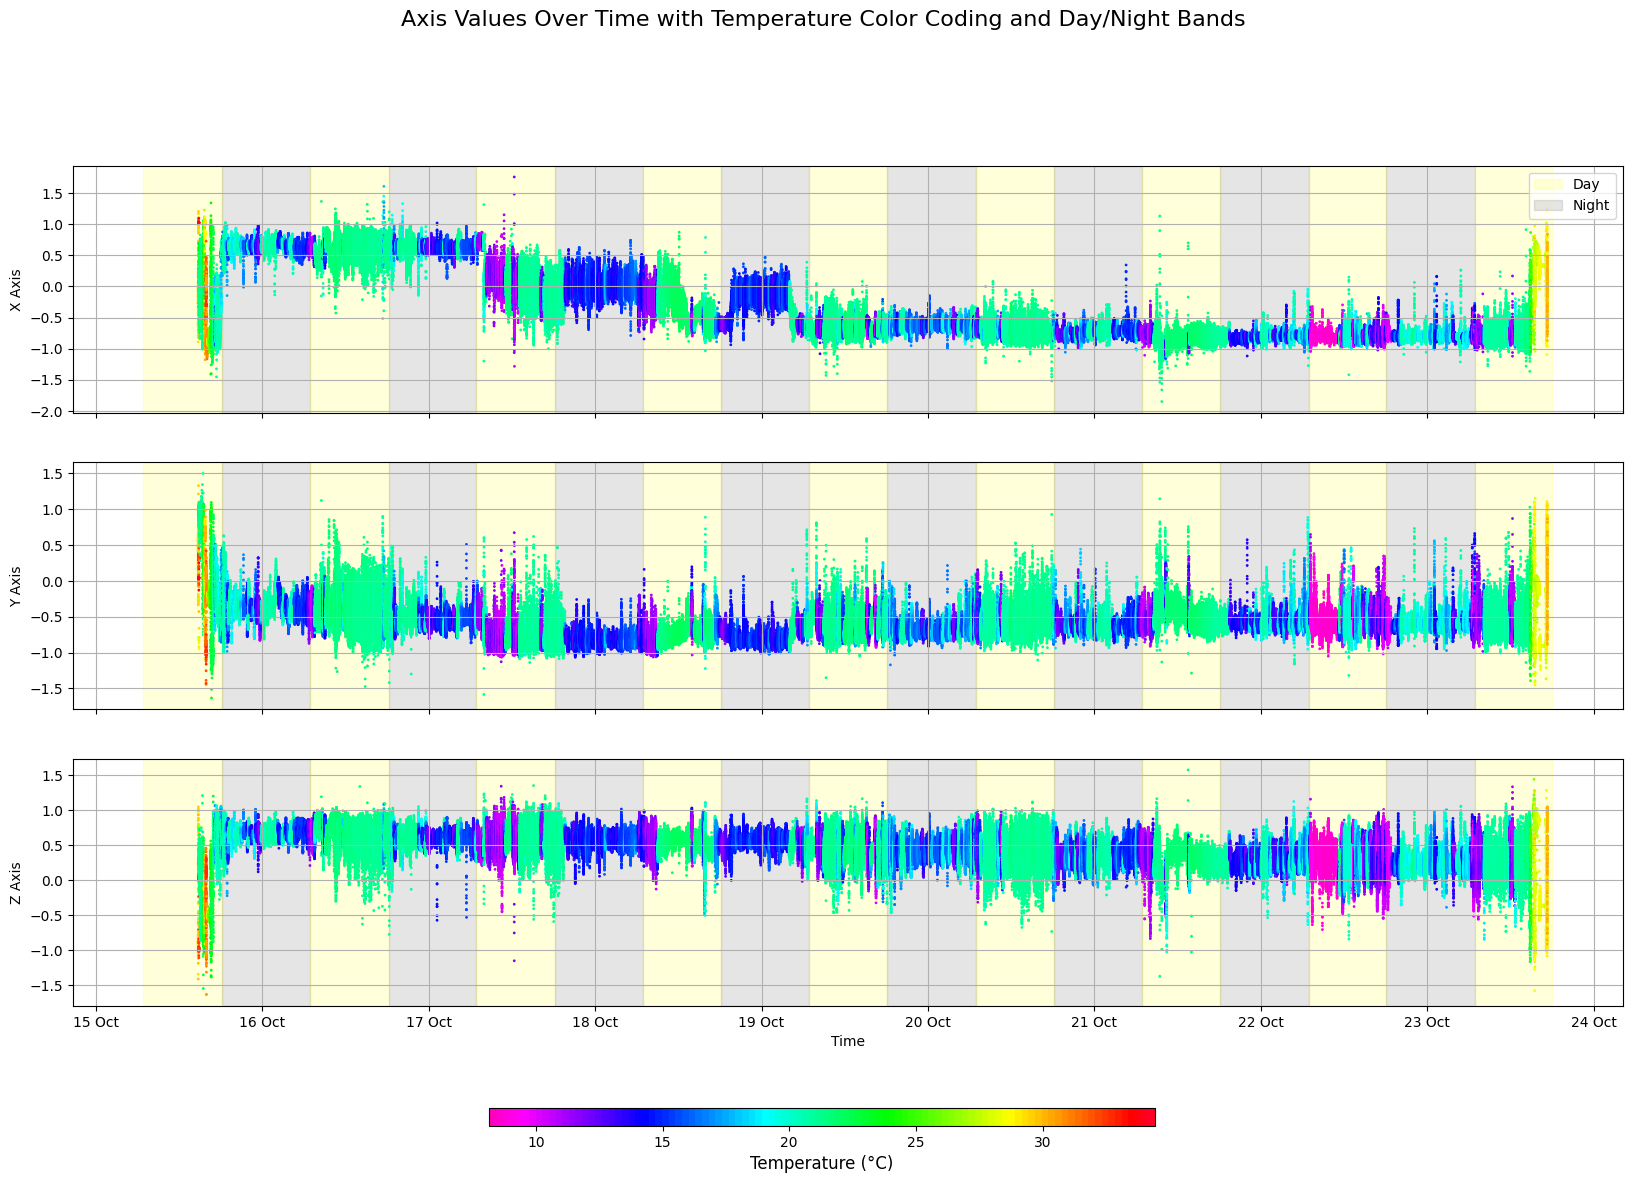

In [21]:
# Create a subplot layout
fig, axs = plt.subplots(3, 1, figsize=(20, 12), sharex=True)

# Store the day/night patches for the legend
day_patch = None
night_patch = None

cmap = plt.get_cmap('gist_rainbow', 100).reversed()
norm = plt.Normalize(vmin=data['Temp'].min(), vmax=data['Temp'].max())

for i, axis in enumerate(['X Axis', 'Y Axis', 'Z Axis']):
    # Plot day-night bands using the sun_cycles dictionary
    for date, times in sun_cycles.items():
        sunrise = times['sunrise']
        sunset = times['sunset']

        day_patch = axs[i].axvspan(sunrise, sunset, color='#FFFF00', alpha=0.15)
        if date != data['Time Stamp'].dt.date.max():
            next_day_sunrise = sun_cycles[date + timedelta(days=1)]['sunrise']
            night_patch = axs[i].axvspan(sunset, next_day_sunrise, color='black', alpha=0.1)

    # Scatter plot for color-coded temperature data
    sc = axs[i].scatter(data['Time Stamp'], data[axis], c=data['Temp'], cmap=cmap, norm=norm, s=1, alpha=1.0)

    axs[i].set_ylabel(f'{axis}')
    axs[i].grid(True)

    # Format the x-axis
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    axs[i].xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Add a legend for day and night bands
axs[0].legend([day_patch, night_patch], ['Day', 'Night'], loc='upper right')

# Set common X-Axis properties
axs[-1].set_xlabel('Time')

# Set the title for the entire figure
fig.suptitle('Axis Values Over Time with Temperature Color Coding and Day/Night Bands', fontsize=16)

# Increase the bottom margin to ensure the colorbar does not overlap with x-axis labels
plt.subplots_adjust(bottom=0.25)

# Adjust the position of the colorbar
# These values are fractions of the figure size. (left, bottom, width, height)
colorbar_axes = fig.add_axes([0.333, 0.05, 0.333, 0.015])

# Create the colorbar with the specified axes and orientation
cbar = plt.colorbar(sc, cax=colorbar_axes, orientation='horizontal')
cbar.set_label('Temperature (°C)', fontsize=12)

# Set the grid for better readability
for ax in axs:
    ax.grid(True)

# Adjust layout
fig.subplots_adjust(bottom=0.15, top=0.85)

# Show the plot
plt.show()